In [1]:
import tikzplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import math
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
import Kernel_and_GP_tools as GP
import My_Tools
import matplotlib.tri as tri
from scipy.interpolate import griddata
from matplotlib import cm
import torch.functional as F

#Own files:
import Kernel_and_GP_tools as GP
import My_Tools
import EquivDeepSets
import EquivCNP

In [2]:
#Construct a random divergence-free VF:
def give_cyclic_div_free(max_radius=2,n_centers=1,l_scale=1.,n_axis=20,sigma_var=1.):
    X_Grid=My_Tools.Radial_Grid(min=-2,max=2,n_axis=n_axis)
    Y=torch.zeros(X_Grid.shape)
    for i in range(n_centers):
        r=np.random.uniform(low=0.0,high=max_radius)
        theta=np.random.uniform(low=0.0,high=2*np.pi)
        X_0=torch.tensor([r*np.cos(theta),r*np.sin(theta)],dtype=torch.get_default_dtype())
        Gram=GP.Gram_matrix(X_Grid,X_0.unsqueeze(0),kernel_type="div_free",l_scale=l_scale,sigma_var=sigma_var)
        rand_vec=torch.randn(size=[2,1])
        Y+=torch.matmul(Gram,rand_vec).view(-1,2)
    return(X_Grid,Y)

def convert_cart_to_polar(X):
    R=torch.norm(X,dim=1)
    Theta=torch.atan2(X[:,1],X[:,0])
    return(torch.stack([Theta,R],dim=1))

def convert_polar_to_cart(X):
    return(X[:,1].unsqueeze(1)*torch.stack([torch.cos(X[:,0]),torch.sin(X[:,0])],dim=1))

def give_radial_div_free(max_radius=2,n_centers=1,l_scale=1.,n_axis=20,sigma_var=1.):
    X,Y=give_cyclic_div_free(max_radius=max_radius,n_centers=n_centers,l_scale=l_scale,n_axis=n_axis,sigma_var=sigma_var)
    return(convert_cart_to_polar(X),convert_cart_to_polar(Y))

In [3]:
shift=np.pi*0.415
n_axis=25
n_context=25
X_polar,Y_polar=give_radial_div_free(n_centers=10,l_scale=1.,sigma_var=1.,n_axis=n_axis)
X_grid=convert_polar_to_cart(X_polar)
Y_grid=convert_polar_to_cart(Y_polar)

X_polar_shift=torch.stack([X_polar[:,0]+shift,X_polar[:,1]],dim=1)
Y_polar_shift=torch.stack([Y_polar[:,0]+shift,Y_polar[:,1]],dim=1)
X_grid_shift=convert_polar_to_cart(X_polar_shift)
Y_grid_shift=convert_polar_to_cart(Y_polar_shift)

ind_cont=torch.randperm(X_polar.size(0))[:n_context]

X_polar_c=X_polar[ind_cont]
Y_grid_c=Y_grid[ind_cont]
X_polar_shift_c=X_polar_shift[ind_cont]
Y_grid_shift_c=Y_grid_shift[ind_cont]

norms=Y_grid.norm(dim=1)
norms_shift=Y_grid_shift.norm(dim=1)

# define grid.
azimuths = np.radians(np.linspace(start=0., stop=360.,num=20))
zeniths = np.linspace(start=0, stop=2.5, num=20)

r, theta = np.meshgrid(zeniths, azimuths)
#values = np.random.random((azimuths.size, zeniths.size))
P_Grid=torch.tensor(np.stack([theta.flatten(),r.flatten()],axis=1))
C_Grid=convert_polar_to_cart(P_Grid)
values=torch.tensor(griddata(X_grid,norms,C_Grid))
values_shifted=torch.tensor(griddata(X_grid_shift,norms_shift,C_Grid))

{'x_range': [-2, 2], 'n_x_axis': 40, 'y_range': [-2, 2], 'n_y_axis': 40, 'l_scale': 0.19999998807907104, 'normalize': True, 'train_l_scale': False}


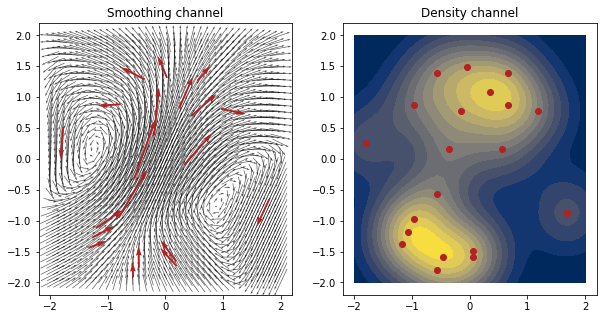

In [64]:
std=1.
n_x_axis=40
n_context=20
encoder=EquivDeepSets.EquivDeepSets([-2,2],40,l_scale=0.2)
print(encoder.give_dict())
X,Y=give_cyclic_div_free(max_radius=1.,n_centers=3,n_axis=n_x_axis,l_scale=1.)
ind_cont=torch.randperm(X.size(0))[:n_context]
X_c=X[ind_cont]
Y_c=Y[ind_cont]
Embedding=encoder(X_c.unsqueeze(0),Y_c.unsqueeze(0))
torch.randperm(X.size(0))[:]
torch.norm(Embedding[0,:,:,1:])
encoder.plot_embedding(Embedding[0],X_c,Y_c,size_scale=1.,quiver_scale=3.)
plt.savefig("Embedding_illustration_1.pdf")

[1.30376095 2.87455728 4.4453536  6.01614993]


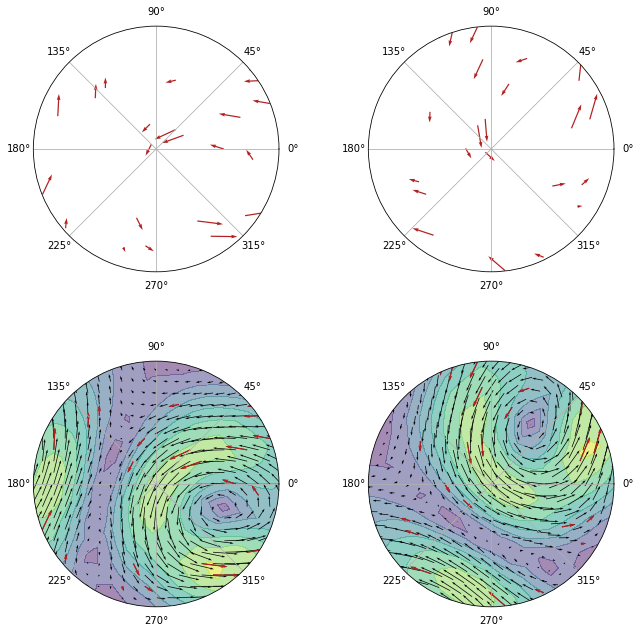

In [16]:
xticks=np.array([0.,np.pi/2,np.pi,3*np.pi/2])
xticks_shift=(xticks+shift)%(2*np.pi)
print(xticks_shift)
R_MAX=1.8
COLMAP=cm.get_cmap('viridis')
QUIV_SCALE=20
CONT_COL='firebrick'
COLDIFF=1.
WIDTH=0.005
ALPHA=0.5
fig  = plt.figure(figsize=(10,10))

ax11=fig.add_subplot(2,2,1, projection='polar')

ax11.set_rmax(1.5)
ax11.set_rticks([])
#ax11.set_xticks(xticks)
#ax11.set_title("Data set",va='bottom')
ax11.quiver(X_polar_c[:,0],X_polar_c[:,1],Y_grid_c[:,0],Y_grid_c[:,1],scale=QUIV_SCALE,width=WIDTH,color=CONT_COL)
#ax11.scatter(X_polar_c[:,0],X_polar_c[:,1],marker='o',c=CONT_COL,s=2)
ax11.set_rmax(R_MAX)

ax12=fig.add_subplot(2,2,2, projection='polar')
ax12.set_rmax(1.5)
ax12.set_rticks([])
#ax12.set_xticks(xticks_shift)

ax12.quiver(X_polar_shift_c[:,0],X_polar_shift_c[:,1],Y_grid_shift_c[:,0],Y_grid_shift_c[:,1],scale=QUIV_SCALE,width=WIDTH,color=CONT_COL)
ax12.set_rmax(R_MAX)

ax21=fig.add_subplot(2,2,3, projection='polar')
ax21.set_rticks([])
#ax21.set_xticks(xticks)
ax21.contourf(theta, r, values.view(20,20),alpha=ALPHA)
ax21.quiver(X_polar[:,0],X_polar[:,1],Y_grid[:,0],Y_grid[:,1],scale=QUIV_SCALE,color='black')#torch.sigmoid(COLDIFF*Y_grid.norm(dim=1)),cmap=COLMAP)
ax21.quiver(X_polar_c[:,0],X_polar_c[:,1],Y_grid_c[:,0],Y_grid_c[:,1],scale=QUIV_SCALE,width=WIDTH,color=CONT_COL,alpha=1.)
ax21.set_rmax(R_MAX)


ax22=fig.add_subplot(2,2,4, projection='polar')
ax22.set_rticks([])
#ax22.set_xticks(xticks_shift)

#ax22.set_title("Rot. prediction.",va='bottom')
#ax22.contourf(theta,r,norms_grid,projection='polar')
#ax22.tricontourf(X_polar_shift[:,0],X_polar_shift[:,1],norms)
ax22.contourf(theta, r, values_shifted.view(20,20),alpha=ALPHA,cmap=COLMAP)
#ax22.tricontourf(X_polar_shift[:,0]+3.141,X_polar_shift[:,1],norms)
ax22.quiver(X_polar_shift[:,0],X_polar_shift[:,1],Y_grid_shift[:,0],Y_grid_shift[:,1],scale=QUIV_SCALE,color='black')
ax22.quiver(X_polar_shift_c[:,0],X_polar_shift_c[:,1],Y_grid_shift_c[:,0],Y_grid_shift_c[:,1],scale=QUIV_SCALE,width=WIDTH,color=CONT_COL,alpha=1.)
#,torch.sigmoid(COLDIFF*Y_grid_shift.norm(dim=1)).cmap=COLMAP)
ax22.set_rmax(R_MAX)

fig.tight_layout(pad=5.)
plt.savefig('Equiv_illustration.pdf')